# Exercise

In this exercise we are going to apply preprocessing steps to a HuggingFace dataset, as well as a local image.

## Loading the dataset

Load the dataset 

In [ ]:
# Udacity workspace only. Comment out if running locally. 
# Fix for huggingface datasets when dealing with
# read-only file-systems
import filelock
import contextlib

# Create a proper no-op FileLock class
class NoOpFileLock:
    def __init__(self, lock_file, *args, **kwargs):
        pass
    
    def __enter__(self):
        return self
    
    def __exit__(self, *args, **kwargs):
        pass

# Replace FileLock with a no-op context manager
filelock.FileLock = NoOpFileLock

In [ ]:
from datasets import load_dataset

# TODO: use the load_dataset function to load the "dev" split of the
# osunlp/MagicBrush dataset
ds = load_dataset("osunlp/MagicBrush", split="dev")

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
import numpy as np


def preprocess_function(examples):
    # Process images
    images = []
    
    for image in examples['source_img']:

        # TODO: apply some preprocessing to the image:
        # - convert to RGB
        # - resize to 256x256. Use .thumbnail to resize and crop if necessary 
        #   or .resize to force the size potentially introducing distortion.
        #.  NOTE: be careful because .thumbnail operates "in-place", it does NOT return
        #.  a resized copy
        image = (
            image
            .convert("RGB")
            # .resize((256, 256))
        )
        image.thumbnail((256, 256))

        images.append(image)
        
    # Add processed images to examples
    examples["preprocessed_image"] = images
    
    return examples

# Apply preprocessing. This adds a new column called
# pixel_values
# NOTE: you need to specify cache_file_name only if your
# dataset is in a read-only file system (like in our Udacity workspace, /data
# is read-only). cache_file_name must be writeable
ds_custom = ds.map(preprocess_function, batched=True, batch_size=9, cache_file_name="/tmp/processed_magicbrush1.arrow").take(9)


(np.float64(-0.5), np.float64(775.5), np.float64(775.5), np.float64(-0.5))

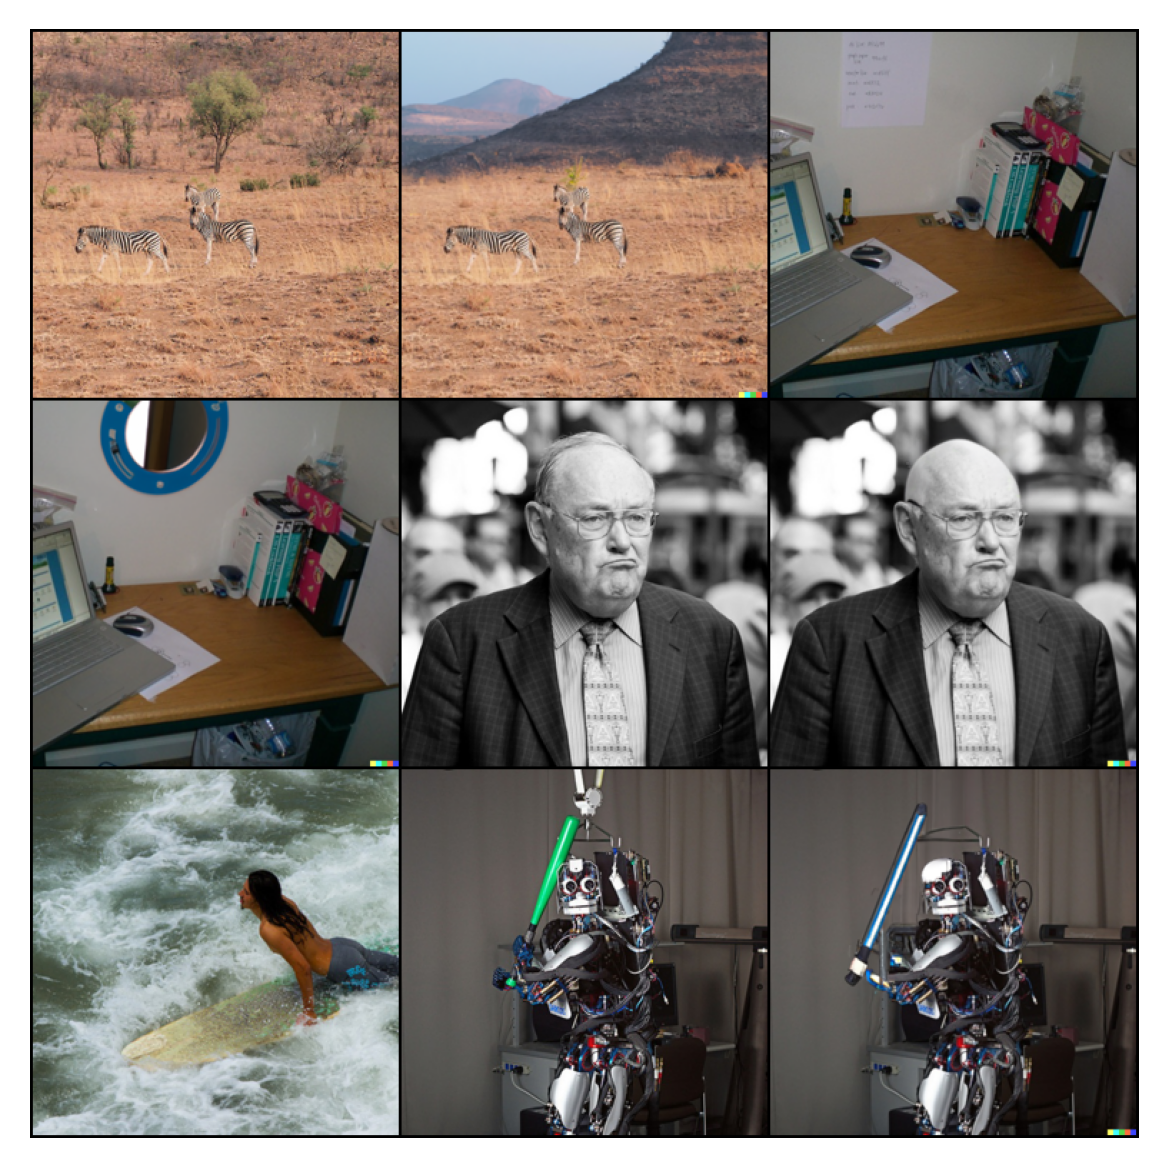

In [ ]:
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

grid = make_grid(
    [
        ToTensor()(img) for img in ds_custom['preprocessed_image']
    ], 
    nrow=3
)

fig, sub = plt.subplots(dpi=300)
sub.imshow(grid.permute(1, 2, 0))
sub.axis('off')

## Apply predefined pre-processing

Now let's apply instead a preprocessor defined by a specific model in the transformers library. This is useful if you then want to apply that model to the image: by using the associated preprocessor you are sure to match what is required by that model.

In [7]:
# NOTE: image-only models usually use the AutoImageProcessor class,
# whereas multimodal models like siglip use typically AutoProcessor.
# They work identically from the application perspective.
from transformers import AutoImageProcessor

# TODO: initialize processor for google/siglip-base-patch16-224
processor = AutoImageProcessor.from_pretrained("google/siglip-base-patch16-224")

# TODO: look at the transformations applied by this pre-processor
print(processor)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

SiglipImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "SiglipImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "processor_class": "SiglipProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [ ]:
def preprocess_function(examples):

    # TODO: convert images to RGB (this is often redundant, 
    # but it is good practice to avoid suprises)
    images = [
        image.convert("RGB") # <- TODO
        for image in examples["source_img"] # NOTE: here you have to use the right column name!
    ]
    
    # TODO: Apply pre-defined processor. Remember to add
    # return tensors = pt as we will need pytorch tensors
    inputs = processor(images, return_tensors="pt")
        
    # Add processed images to examples
    examples["pixel_values"] = inputs["pixel_values"]
    
    return examples

# Apply preprocessing. This adds a new column called
# pixel_values
# NOTE: you need to specify cache_file_name only if your
# dataset is in a read-only file system (like in our Udacity workspace, /data
# is read-only). cache_file_name must be writeable
ds_processed = ds.map(preprocess_function, batched=True, batch_size=9, cache_file_name="/tmp/processed_magicbrush2.arrow").take(9)

hey


(np.float64(-0.5), np.float64(679.5), np.float64(679.5), np.float64(-0.5))

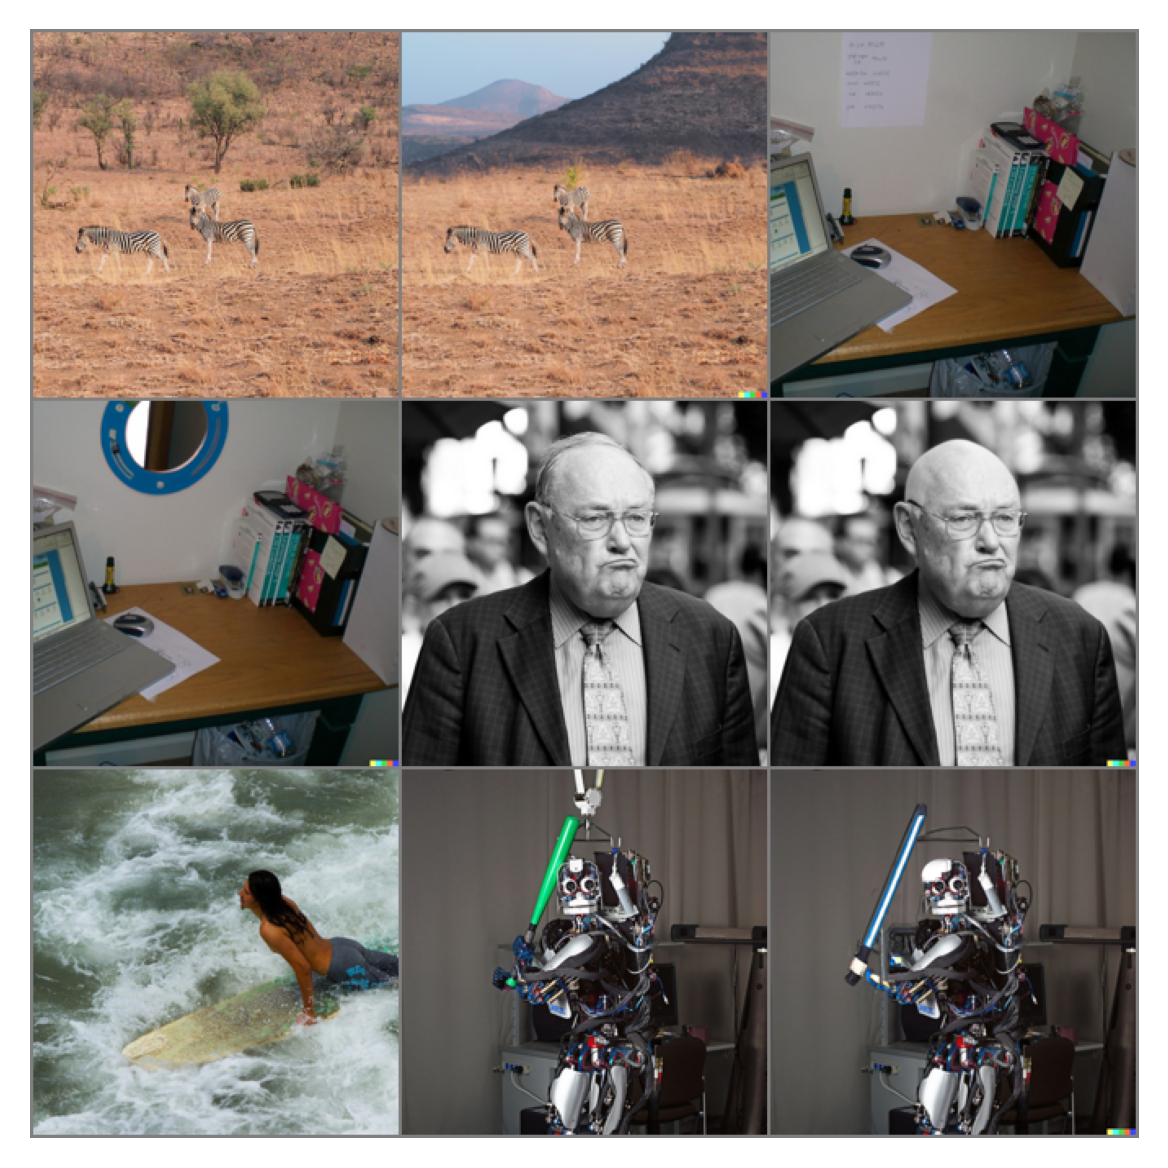

In [13]:
# NOTE: here we do not call ToTensor because the preprocessed images are
# already in tensor format
grid = make_grid([img for img in ds_processed['pixel_values']], nrow=3)

# NOTE: because the preprocessor standardizes the data, the resulting
# tensors are not between 0 and 255 like the input images, they are instead
# float values. Matplotlib can handle this, but only if we normalize it 
# before plotting to be between 0 and 1. This is needed only for plotting
# and should NOT be done on the tensors that are given to downstream models
grid -= grid.min()
grid /= grid.max()

fig, sub = plt.subplots(dpi=300)
sub.imshow(grid.permute(1, 2, 0))
sub.axis('off')